In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import random

In [2]:
#Architecture parameters and distributions of stimuli
N = 20
K = 10
p_x = torch.distributions.exponential.Exponential(0.5)

#Training parameters
#(Note that in this toy model we can generate as many data as we want, since the distribution is relatively simple, so the distinction between N_SAMPLES and BATCH_SIZE is not very neat)
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]


#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)

#inv_sigma2.shape
enc.cs.shape
#x_fine.shape
#x_sorted.shape


torch.Size([1, 20])

In [3]:
initialize_bernoulli_params(N,x_min,x_max,x_sorted)

(Parameter containing:
 tensor([[1.1339, 0.9338, 4.5015, 0.7334, 2.7589, 1.3863, 0.4948, 8.2128, 5.0548,
          0.6011, 0.1032, 3.8550, 0.8299, 1.7388, 0.6613, 3.3326, 2.2063, 5.8146,
          6.6811, 0.3182]], requires_grad=True),
 Parameter containing:
 tensor([[-0.6874, -0.6874, -0.6874, -0.6874, -0.6874, -0.6874, -0.6874, -0.6874,
          -0.6874, -0.6874, -0.6874, -0.6874, -0.6874, -0.6874, -0.6874, -0.6874,
          -0.6874, -0.6874, -0.6874, -0.6874]], requires_grad=True),
 Parameter containing:
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.]], requires_grad=True))

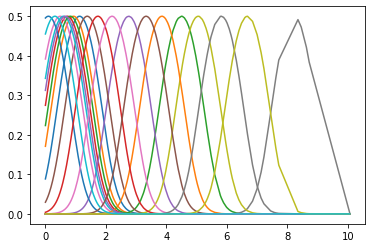

In [4]:
phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)  #(-mu/(sigma)^2 , -1/2*(sigma^2))
dec = GaussianDecoder(phi0)



plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())


In [6]:

lossVec = []
mseVec = []
params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        loss = distortion_gaussian(x_,enc,dec) 
        lossVec.append(loss.item())
        #print(torch.softmax(decoder.qs,dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

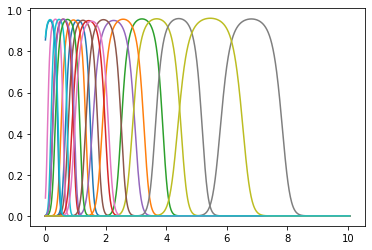

In [7]:
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach());

In [17]:
a = F.sigmoid(enc(x_fine[-1:,0]))
a

C:\Users\auror\anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.5481e-14, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.9469e-27, 0.0000e+00]], grad_fn=<SigmoidBackward>)

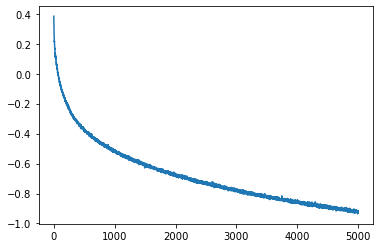

In [8]:
plt.plot(lossVec)

In [20]:
r = enc.sample(x_fine[-1:,0],10)
r
dec(r)


(tensor([[8.6993, 8.6993, 8.6993, 8.6993, 8.6993, 8.6993, 8.6993, 8.6993, 8.6993,
          8.6993]], grad_fn=<DivBackward0>),
 tensor([[2.5484, 2.5484, 2.5484, 2.5484, 2.5484, 2.5484, 2.5484, 2.5484, 2.5484,
          2.5484]], grad_fn=<MulBackward0>))

In [22]:
#Fixed sigma
DVec = []
DtVec = []
RVec = []

for sigmai in np.arange(0.01,0.2,0.01):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2)
    enc.log_sigmas = torch.nn.Parameter(torch.log(sigmai*torch.ones(N)[None,:]))
    inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)
    phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)
    dec = GaussianDecoder(phi0)
    DVec.append(distortion_gaussian(x_sorted,enc,dec,tau=0.1).item())
    DtVec.append(distortion_ideal(x_sorted,enc,tau=0.1).item())
    l_r_x = enc(x_sorted)
    #Dkl between two bernoulli distributions
    x_k = x_sorted[random.sample(range(500),K)]
    R =rate_vampBernoulli(x_sorted,enc,x_k)
    #print(R)
    RVec.append(R.item())
    


tensor([9.9800])


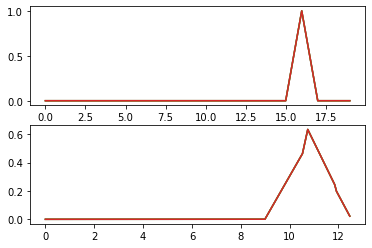

In [69]:
r = enc.sample(x_fine,10)
ix = 800
print(x_fine[ix])
mu_dec,sigma2_dec = dec(r)
with torch.no_grad():
    nsample =[1,3,5,7]
    fig,(ax1,ax2) = plt.subplots(2)
    q_x_r = torch.exp(torch.distributions.normal.Normal(mu_dec[ix,nsample],torch.sqrt(sigma2_dec[ix,nsample])).log_prob(x_sorted))
    ax1.plot(range(N),r[ix,nsample,:].transpose(0,1))
    ax2.plot(x_sorted,q_x_r)
    #plt.show()
    

In [15]:
for x_ in x_data:
    print(distortion_gaussian(x_,enc,dec))

tensor(-0.2149, grad_fn=<NegBackward>)


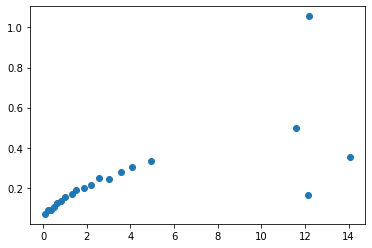

In [44]:
plt.scatter(enc.cs.detach(),torch.exp(enc.log_sigmas).detach())

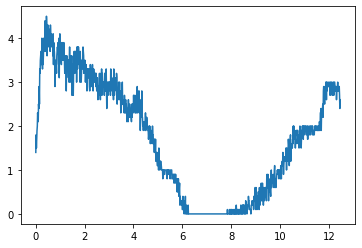

In [67]:
r = enc.sample(x_fine,10)
plt.plot(x_fine,r.sum(dim=2).mean(dim=1).detach())

In [62]:
dec.b

Parameter containing:
tensor([10.3297, -0.7585], requires_grad=True)

In [63]:
x_sorted.mean()

tensor(2.0816)

In [66]:
10/(2*0.75)

6.666666666666667